In [119]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import timm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

CURRENT_DIR = os.getcwd()

In [120]:
class WikiArtDataset(Dataset):
    def __init__(self, h5_path: str, mask_h5_path: str, csv_path: str, set_type: str, group_filter=None, transform=None, mask_transform=None):
        self.h5_path = h5_path
        self.mask_h5_path = mask_h5_path
        self.transform = transform
        self.mask_transform = mask_transform

        # Load the CSV file
        self.df = pd.read_csv(csv_path)
        
        # Filter the dataframe based on the set_type
        self.df = self.df[self.df['set_type'] == set_type]

        if group_filter is not None:
            self.df = self.df[self.df['cluster_label'] == group_filter]
        
        with h5py.File(self.h5_path, 'r') as h5f:
            self.length = len(self.df)
        
        with h5py.File(self.mask_h5_path, 'r') as mask_h5f:
            self.num_masks = mask_h5f['mask'].shape[0]  # Number of masks available

    def __len__(self):
        return self.length

    def _open_hdf5(self):
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')

        if not hasattr(self, '_mask_hf') or self._mask_hf is None:
            self._mask_hf = h5py.File(self.mask_h5_path, 'r')

    def _get_random_mask(self):
        mask_idx = np.random.randint(0, self.num_masks)
        mask = self._mask_hf['mask'][mask_idx]
        return mask

    def __getitem__(self, idx):
        self._open_hdf5()

        # Get the index from the dataframe
        row = self.df.iloc[idx]
        image_idx = row['index']
        cluster_label = row['cluster_label']

        image = self._hf['image'][image_idx]
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        mask = self._get_random_mask()
        mask = torch.from_numpy(mask).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, cluster_label

In [121]:
class UNetInpainting(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout

        # Pre-trained encoder using timm
        self.encoder = timm.create_model('resnet34', pretrained=True, features_only=True, out_indices=(0, 1, 2, 3, 4))
        encoder_channels = self.encoder.feature_info.channels()  # Channels for each encoder block

        # Decoder
        self.decoder4 = self.upconv_block(encoder_channels[-1], encoder_channels[-2])
        self.decoder3 = self.upconv_block(encoder_channels[-2], encoder_channels[-3])
        self.decoder2 = self.upconv_block(encoder_channels[-3], encoder_channels[-4])
        self.decoder1 = self.upconv_block(encoder_channels[-4], encoder_channels[-5])

        # Final upsampling to 256x256 and output
        self.final_upconv = nn.ConvTranspose2d(encoder_channels[-5], 64, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x, mask):
        # Apply the mask to the input image
        masked_image = x * (1 - mask)

        # Encoder pass
        features = self.encoder(masked_image)
        e1, e2, e3, e4, e5 = features

        # Bottleneck
        b = e5

        # Decoder with skip connections
        d4 = self.decoder4(b) + e4
        d3 = self.decoder3(d4) + e3
        d2 = self.decoder2(d3) + e2
        d1 = self.decoder1(d2) + e1

        # Final upsampling and output
        output = self.final_upconv(d1)
        output = self.final_conv(output)

        return output

In [122]:
def load_model(checkpoint_path, model_class, device='cpu'):
    model = model_class()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

In [123]:
def visualize_results(original, masked, mask, output):
    original = original.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    masked = masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    mask = mask.squeeze(0).cpu().numpy().astype(np.uint8)
    output = output.permute(1, 2, 0).detach().cpu().numpy().clip(0, 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(original)
    ax[0].set_title('Original')
    ax[1].imshow(masked)
    ax[1].set_title('Masked')
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title('Mask')
    ax[3].imshow(output)
    ax[3].set_title('Output')
    for a in ax:
        a.axis('off')
    plt.show()

In [124]:
def evaluate_sample(dataset, model, device='cuda'):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.to(device)

    for batch in dataloader:
        images, masks, label = batch
        images, masks = images.to(device), masks.to(device)

        masked_image = images * (1 - masks.unsqueeze(1))

        with torch.no_grad():
            output = model(images, masks.unsqueeze(1))

        visualize_results(
            original=images[0],
            masked=masked_image[0],
            mask=masks[0],
            output=output[0]
        )

        print('Cluster label:', label.item())
        break

In [125]:
model_paths = {
    0 : f'{CURRENT_DIR}\\weights\\0\\best_weights_epoch_46_val_loss_24.9703-4417.pth',
    1 : f'{CURRENT_DIR}\\weights\\1\\best_weights_epoch_84_val_loss_20.6325-2379.pth',
    2 : f'{CURRENT_DIR}\\weights\\2\\best_weights_epoch_45_val_loss_14.0691-4231.pth',
    3 : f'{CURRENT_DIR}\\weights\\3\\best_weights_epoch_97_val_loss_23.3337-1273.pth',
    4 : f'{CURRENT_DIR}\\weights\\4\\best_weights_epoch_88_val_loss_25.4863-1512.pth',
    5 : f'{CURRENT_DIR}\\weights\\5\\best_weights_epoch_79_val_loss_24.8253-2159.pth',
    6 : f'{CURRENT_DIR}\\weights\\6\\best_weights_epoch_73_val_loss_26.2931-2145.pth'
}

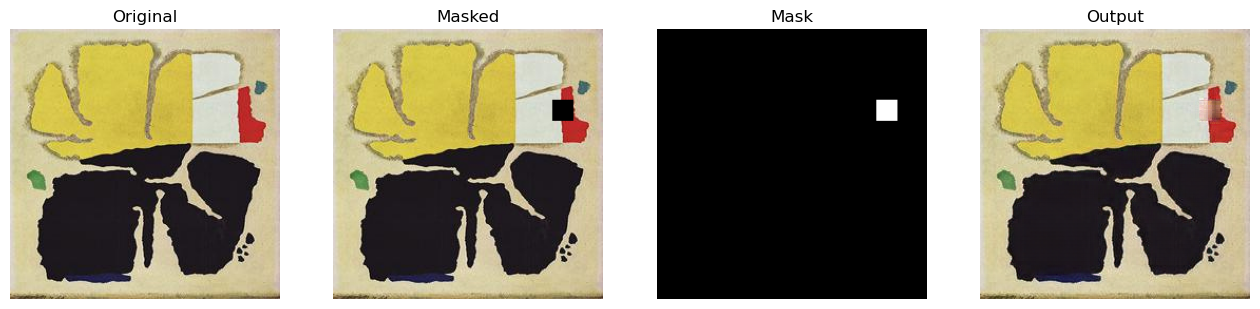

Cluster label: 0


In [132]:
GROUP_ID = 0

h5_path = f'{CURRENT_DIR}\\wikiart\\dataset.h5'
annotations_path = f'{CURRENT_DIR}\\wikiart\\clustered_full_split.csv'
mask_h5_path = f'{CURRENT_DIR}\\masks\\square.h5'

test_dataset = WikiArtDataset(h5_path, mask_h5_path, annotations_path, 'test', group_filter=GROUP_ID)

model = load_model(model_paths[GROUP_ID], UNetInpainting)

evaluate_sample(test_dataset, model, device='cpu')